<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [13]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

In [14]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers

## 1.3 Import Dataset

In [15]:
#Load the DataFrames from the .pkl files
with open("../data/train_df.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/val_df.pkl", "rb") as f:
     val_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

with open("../data/train_df_sampled.pkl", "rb") as f:
     train_df_sampled = pickle.load(f)

with open("../data/family_encoder.pkl", "rb") as f:
     family_encoder = pickle.load(f)

<div class="alert alert-block alert-success">

# **2.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [16]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [17]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224)

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(data_dir="../data/rare_species/train", minority_class=minority_class, augment=None, oversampling=True)
train_ds_sampled, class_names = preprocess.load_img(data_dir="../data/rare_species/train_sampled", minority_class=minority_class, augment=None, oversampling=True)
val_ds, _ = preprocess.load_img(data_dir="../data/rare_species/val", minority_class=minority_class, augment=None, oversampling=False)
test_ds, _ = preprocess.load_img(data_dir="../data/rare_species/test", minority_class=minority_class, augment=None, oversampling=False)

Found 8388 files belonging to 202 classes.
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


2025-04-16 16:47:37.659198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


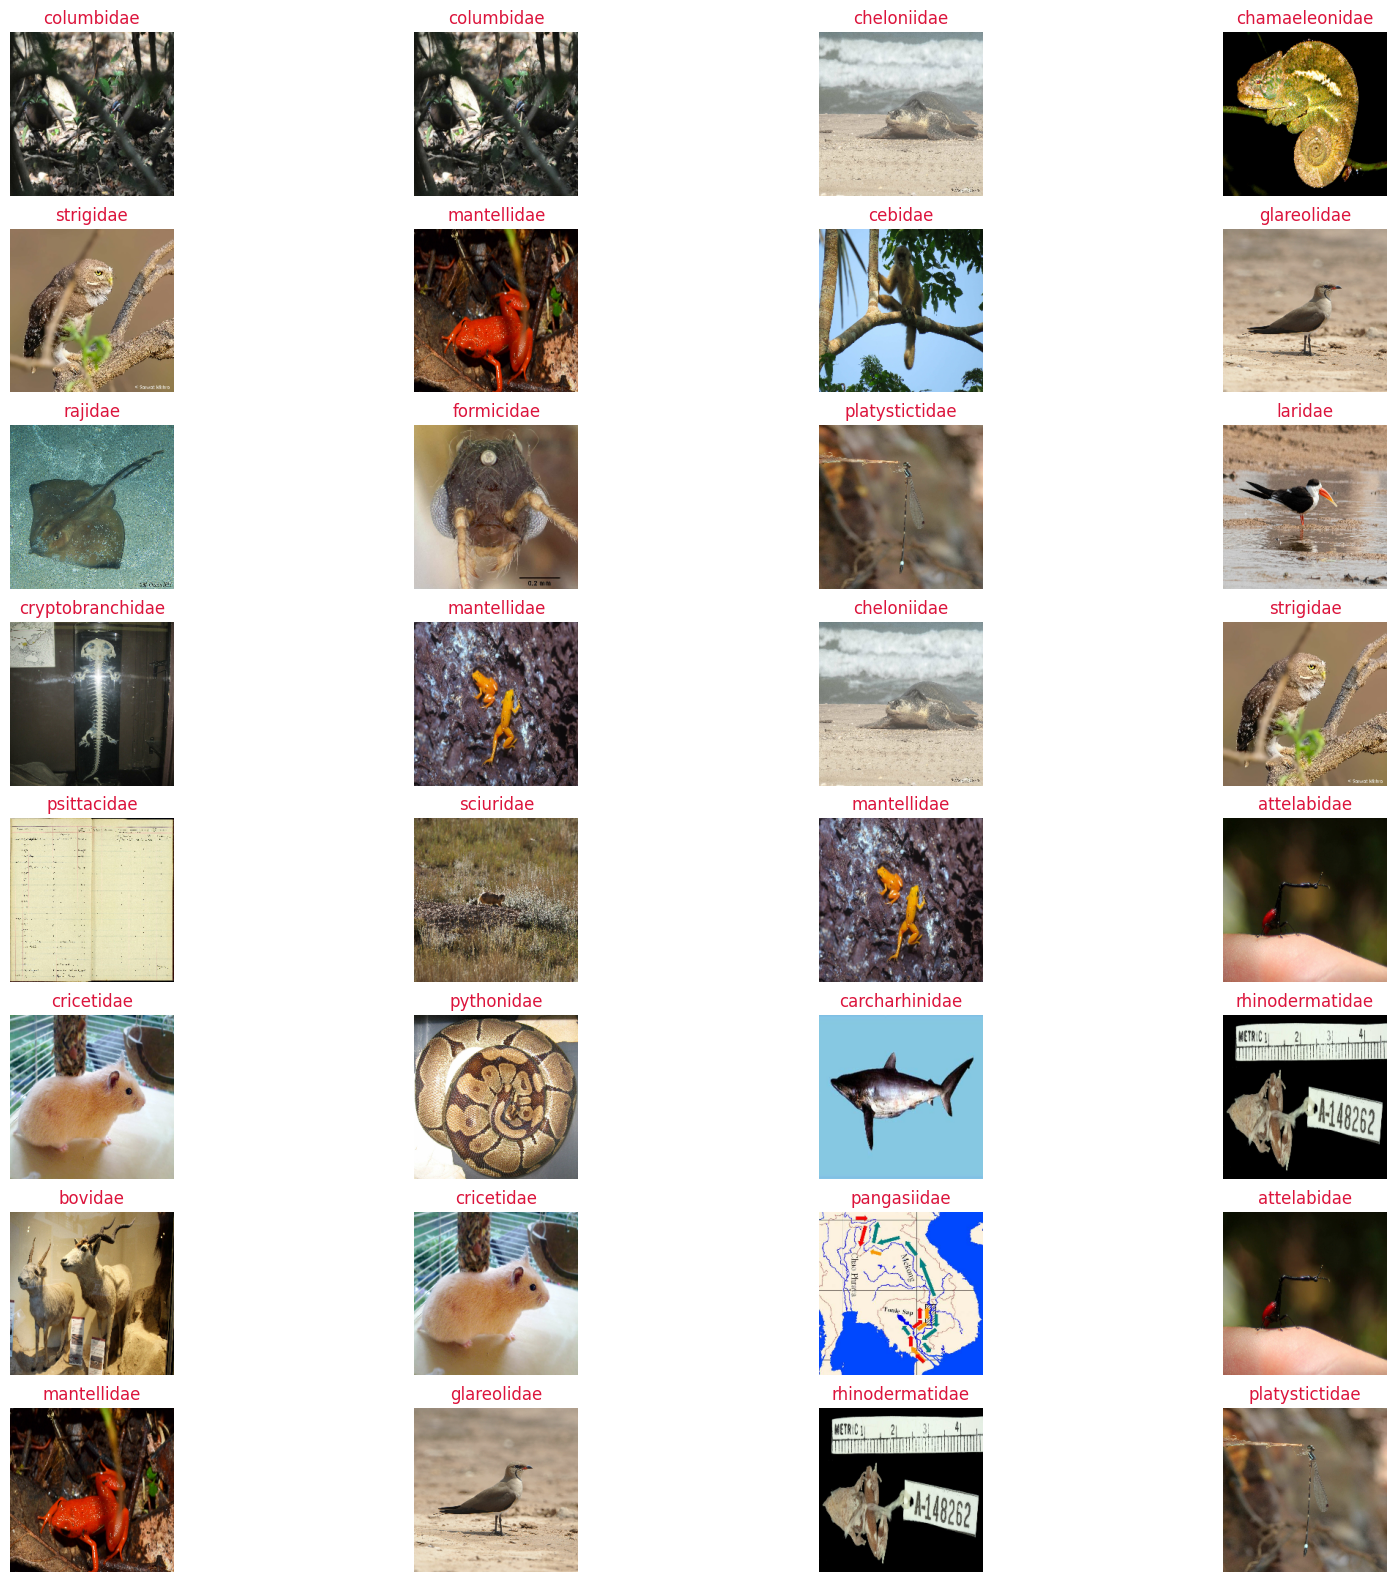

In [18]:
num_images = 32 ##
rows, cols = 8, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

## (augmentations)

In [19]:
# augmentations_to_test = [
#     # "none",
#     # "light",
#     # "medium",
#     # "heavy",
#     # "grayscale",
#     # "randaugment",
#     "mixup",
#     "cutmix"]

<!-- ##### Simple model do test augmentations -->

In [20]:
# def build_model(num_classes):
#     base = keras.applications.EfficientNetB0(
#         input_shape=(224, 224, 3),
#         include_top=False,
#         weights="imagenet",
#         pooling="avg"
#     )
#     base.trainable = False  # You can fine-tune later

#     inputs = keras.Input(shape=(224, 224, 3))
#     x = base(inputs, training=False)
#     x = keras.layers.Dropout(0.2)(x)
#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     return keras.Model(inputs, outputs)

In [21]:
# def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
#     """Return a sampled subset of the dataset."""
#     if fraction:
#         dataset = dataset.shuffle(1000, seed=seed)
#         dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
#     elif num_batches:
#         dataset = dataset.take(num_batches)
#     return dataset

<!-- ##### Loop -->

In [22]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=5,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


In [23]:
# augmentations_to_test = [
#     "none",
#     "light",
#     "medium",
#     "heavy",
#     "grayscale",
#     "randaugment",
#     "mixup",
#     "cutmix"]

In [24]:
# # Initialize the preprocessor
# pre = Preprocessor(image_size=(224, 224), batch_size=32)

# # Store results
# results = {}

# # Loop through each augmentation
# for aug in augmentations_to_test:
#     print(f"\nTraining with augmentation: {aug}")

#     # Load datasets
#     train_ds, class_names = pre.load_img(
#         data_dir="../data/rare_species/train",
#         augment=aug
#     )

#     val_ds, _ = pre.load_img(
#         data_dir="../data/rare_species/val",
#         augment=None
#     )

#     # Sample a subset of training data
#     train_ds = sample_dataset(train_ds, fraction=0.5)

#     # Build a fresh model (you should define this function)
#     model = build_sequential_model(list_of_layers=layers)

#     # Compile
#     model.compile(
#         optimizer="adam",
#         loss="categorical_crossentropy",
#         metrics=["accuracy"]
#     )

#     # Train
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=15,
#         verbose=1
#     )

#     # Predict entire validation set at once
#     preds = model.predict(val_ds)
#     y_pred = np.argmax(preds, axis=1)

#     # Extract true labels in order
#     y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

#     # Compute metrics
#     f1_macro = f1_score(y_true, y_pred, average='macro')
#     f1_weighted = f1_score(y_true, y_pred, average='weighted')
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')

#     # Store in results
#     results[aug] = {
#         "val_accuracy": history.history["val_accuracy"][-1],
#         "f1_macro": f1_macro,
#         "f1_weighted": f1_weighted,
#         "precision": precision,
#         "recall": recall
#     }

#     print(f"Finished '{aug}'")
#     print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
#     print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
#     print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
#     print(f"  Precision:     {results[aug]['precision']:.4f}")
#     print(f"  Recall:        {results[aug]['recall']:.4f}")


<div class="alert alert-block alert-success">

# **3.** Models

<div>

## 3.1 Callbacks

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

In [26]:
# Add callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    # ,EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", verbose=1)
]

## 3.2 LeNet

In [17]:
def build_lenet(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Layer 1: Conv → Tanh → AvgPool
    model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', padding='same',
                     input_shape=input_shape, kernel_regularizer=l2(1e-4)))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=2))

    # Layer 2: Conv → Tanh → AvgPool
    model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh', padding='valid',
                     kernel_regularizer=l2(1e-4)))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=2))

    # Layer 3: Conv → Tanh
    model.add(Conv2D(120, kernel_size=(5, 5), activation='tanh', padding='valid',
                     kernel_regularizer=l2(1e-4)))

    # Flatten
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(84, activation='tanh', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_lenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 300000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 84)             │    25,200,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │        17,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,268,246 (96.39 MB)

 Trainable params: 25,268,246 (96.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="lenet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/10


2025-04-16 16:02:10.761683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.0081 - loss: 5.8041 - val_accuracy: 0.0250 - val_loss: 5.2148 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.0174 - loss: 5.5700 - val_accuracy: 0.0250 - val_loss: 5.1854 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.0167 - loss: 5.5394 - val_accuracy: 0.0250 - val_loss: 5.1766 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.0123 - loss: 5.4979 - val_accuracy: 0.0250 - val_loss: 5.1845 - learning_rate: 0.0010
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0155 - loss: 5.4891
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.0155 - loss: 5.4890 - val_accuracy: 0.0250 - val_loss: 5.1827 - learning_rate: 0.0010
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.0165 - loss: 5

## 3.3 AlexNet

In [19]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Flatten and FC
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_alexnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,576,010 (181.49 MB)

 Trainable params: 47,575,306 (181.49 MB)

 Non-trainable params: 704 (2.75 KB)

In [21]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="alexnet_without_aug_2",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 327ms/step - accuracy: 0.0148 - loss: 7.6593 - val_accuracy: 0.0223 - val_loss: 5.9132 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 377ms/step - accuracy: 0.0177 - loss: 5.9635 - val_accuracy: 0.0239 - val_loss: 5.7677 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 414ms/step - accuracy: 0.0186 - loss: 5.8165 - val_accuracy: 0.0250 - val_loss: 5.6328 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.0178 - loss: 5.6974 - val_accuracy: 0.0250 - val_loss: 5.5379 - learning_rate: 0.0010
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 373ms/step - accuracy: 0.0187 - loss: 5.6132 - val_accuracy: 0.0250 - val_loss: 5.4624 - learning_rate: 0.0010
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 368ms/step - accuracy: 0.0179 - loss: 5.5425 - val_accuracy: 0.0250 - val_loss: 5.4027 - learning_rate: 0.0010
Epoch 7/10
175/175 ━━━━━━━

## 3.4 ZF net

It’s very similar to AlexNet but with:

Smaller initial filters (7×7 instead of 11×11),
Smaller strides,
Overall more fine-grained feature extraction early on.

In [27]:
def build_zfnet(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv2D(96, (7, 7), strides=2, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Conv Layer 2
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Conv Layer 3
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 4
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Conv Layer 5
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model\

model = build_zfnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 109, 109, 96)   │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 54, 54, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   150,999,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 202)            │       827,594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,335,818 (657.41 MB)

 Trainable params: 172,335,114 (657.41 MB)

 Non-trainable params: 704 (2.75 KB)

In [28]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="zfnet_without_aug_2",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

Resuming training from epoch 1
Could not read log or load model: 
Starting from scratch.
Epoch 2/10


2025-04-16 16:48:00.020940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0040 - loss: 84890.7891

OSError: [Errno 28] No space left on device

## 3.5 GoogLeNet

Uses Inception modules to capture multi-scale features

- Good balance of depth and efficiency.
- Excellent at capturing fine-grained details (your dataset has many classes with subtle visual differences).
- Faster to train than ResNet or Transformers.

### Inception v1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

def inception_module(x, f1, f3_in, f3_out, f5_in, f5_out, pool_proj):
    path1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(f3_out, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(f5_in, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(f5_out, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(pool_proj, (1, 1), padding='same', activation='relu')(path4)

    return concatenate([path1, path2, path3, path4], axis=-1)

def build_googlenet(input_shape=(224, 224, 3), num_classes=202):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, x)

model = build_googlenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


In [ ]:
model = build_googlenet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="googlenet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

## 3.6 VGGNet

inspired by VGG16 — a deep and uniform architecture with 3x3 convolutions and max pooling.

In [ ]:
def build_vgg_model(input_shape=(224, 224, 3), num_classes=202):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Block 4 (optional to reduce overfitting)
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="vggnet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

## 3.7 ResNets

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # First conv layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second conv layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Downsample the shortcut if needed
    if downsample:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add skip connection
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Initial convolution and max pooling
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, downsample=True)
    x = residual_block(x, 512)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_resnet18()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


2025-04-16 16:24:57.689454: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-16 16:24:57.689474: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-16 16:24:57.689477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-16 16:24:57.689492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-16 16:24:57.689502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,294,538 (43.09 MB)

 Trainable params: 11,284,938 (43.05 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:


def build_optimized_model(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)

    # Shared conv base
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Parallel paths
    conv1 = Conv2D(32, (1, 1), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv3 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    conv5 = Conv2D(32, (5, 5), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)

    x = Concatenate()([conv1, conv3, conv5])
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Another conv block
    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Final feature compression
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Build and compile
model = build_optimized_model()

In [26]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        "accuracy"
    ]
)

In [27]:
# # Initialize the experiment
# experiment = Experiment(
#     model=model,
#     train_ds=train_ds_sampled,
#     val_ds=val_ds,
#     experiment_name="parallel_mixup_withou_phylum",
#     batch_size=32,
#     image_size=(224, 224)
# )

# # Default callbacks
# # ExperimentLogger,  # Log experiment results after each epoch
# # EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# # ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# # Run the experiment
# history = experiment.run_experiment(callbacks=callbacks, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_simple_functional_cnn(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)
    
    # Block 1: Extract low-level features.
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (112, 112, 32)
    
    # Block 2: Increase depth with more complex features.
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (56, 56, 64)
    
    # Block 3: Extract even higher-level representations.
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)  # Output shape: (28, 28, 128)
    
    # Global Feature Aggregation
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # Dense layers for classification
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_simple_functional_cnn()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 202)            │        51,914 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,082 (699.54 KB)

 Trainable params: 178,634 (697.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
history = model.fit(
    train_ds_sampled,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Optionally, you can inspect the training history:
print(history.history)

Epoch 1/10


175/175 ━━━━━━━━━━━━━━━━━━━━ 85s 466ms/step - accuracy: 0.0095 - loss: 5.8826 - val_accuracy: 0.0273 - val_loss: 5.2290 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 63s 355ms/step - accuracy: 0.0088 - loss: 6.3158 - val_accuracy: 0.0161 - val_loss: 6.2324 - learning_rate: 0.0040
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.0098 - loss: 7.8005
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.
175/175 ━━━━━━━━━━━━━━━━━━━━ 76s 435ms/step - accuracy: 0.0098 - loss: 7.8009 - val_accuracy: 0.0078 - val_loss: 13.8024 - learning_rate: 0.0035
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 77s 438ms/step - accuracy: 0.0070 - loss: 7.6631 - val_accuracy: 0.0178 - val_loss: 8.0339 - learning_rate: 0.0100
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.0124 - loss: 6.0030
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004749999847263098.
175/175 ━━━━━━━━━━━━━━━━━━━━ 79s 453ms/step - accuracy: 0.0124 - loss: 6.0

In [34]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="hybrid_cnn_transformer_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

No checkpoint found, starting from scratch.
Epoch 1/10


2025-04-15 19:17:43.119067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


135/175 ━━━━━━━━━━━━━━━━━━━━ 1:53 3s/step - accuracy: 0.0072 - loss: 5.7882

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, ReLU, Add,
                                     GlobalAveragePooling2D, Reshape, Multiply, Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block."""
    channel_dim = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)  # Squeeze: (batch, channels)
    se = Dense(channel_dim // reduction, activation='relu', kernel_regularizer=l2(1e-4))(se)
    se = Dense(channel_dim, activation='sigmoid', kernel_regularizer=l2(1e-4))(se)
    se = Reshape((1, 1, channel_dim))(se)
    x = Multiply()([input_tensor, se])
    return x

def residual_se_block(x, filters, kernel_size=(3,3), stride=1):
    shortcut = x
    # First conv layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    # Second conv layer
    x = Conv2D(filters, kernel_size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    
    # Apply SE block
    x = se_block(x)
    
    # If dimensions differ, use a projection shortcut.
    if stride != 1 or int(shortcut.shape[-1]) != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

def build_custom_se_resnet(input_shape=(224, 224, 3), num_classes=202):
    inputs = Input(shape=input_shape)
    
    # Initial Block
    x = Conv2D(64, (7, 7), strides=2, padding="same", activation="relu", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=2, padding="same")(x)
    
    # Residual SE Blocks
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)
    x = residual_se_block(x, 64, kernel_size=(3, 3), stride=1)
    
    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 128, kernel_size=(3, 3), stride=1)
    
    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=2)
    x = residual_se_block(x, 256, kernel_size=(3, 3), stride=1)
    
    # Global Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs, outputs)

# Build and compile the model
model = build_custom_se_resnet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


In [ ]:
# Initialize the experiment
experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="custom_se_resnet_without_aug",
    batch_size=32,
    image_size=(224, 224)
)

# Default callbacks
# ExperimentLogger,  # Log experiment results after each epoch
# EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping callback
# ModelCheckpoint(checkpoint_file, save_best_only=True)  # Save best model based on validation performance

# Run the experiment
history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

In [ ]:
model = models.Sequential([
    
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(202, activation='softmax')
])

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=metrics
)

model.summary()

experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="gui0",
    batch_size=32,
    image_size=(224, 224)
)

history = experiment.run_experiment(callbacks=callbacks, epochs=10) # callbacks=None use default callbacks (created in the Experiment class)

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,499,722 (169.75 MB)

 Trainable params: 44,499,722 (169.75 MB)

 Non-trainable params: 0 (0.00 B)

No checkpoint found, starting from scratch.
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.0158 - auc: 0.5386 - f1_macro: 0.0013 - f1_weighted: 0.0043 - loss: 5.6008 - top5_accuracy: 0.0660 - val_accuracy: 0.0373 - val_auc: 0.6264 - val_f1_macro: 0.0023 - val_f1_weighted: 0.0107 - val_loss: 5.1417 - val_top5_accuracy: 0.1408 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 734s 4s/step - accuracy: 0.0188 - auc: 0.5878 - f1_macro: 0.0019 - f1_weighted: 0.0054 - loss: 5.2588 - top5_accuracy: 0.0882 - val_accuracy: 0.0250 - val_auc: 0.6375 - val_f1_macro: 2.4188e-04 - val_f1_weighted: 0.0012 - val_loss: 5.1136 - val_top5_accuracy: 0.1185 - learning_rate: 0.0040
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.0165 - auc: 0.5772 - f1_macro: 7.2866e-04 - f1_weighted: 0.0028 - loss: 5.2313 - top5_accuracy: 0.0852 - val_accuracy: 0.0223 - val_auc: 0.6370 - val_f1_macro: 2.1653e-04 - val_f1_weighted: 9.7362e-04 - val_loss: 5.1100 - val_top5_

In [19]:
model = models.Sequential([
    
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(202, activation='softmax')
])

metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_macro"),
    F1Score(average="weighted", name="f1_weighted"),
    TopKCategoricalAccuracy(k=5, name="top5_accuracy")
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=metrics
)

model.summary()

experiment = Experiment(
    model=model,
    train_ds=train_ds_sampled,
    val_ds=val_ds,
    experiment_name="gui1",
    batch_size=32,
    image_size=(224, 224)
)

history = experiment.run_experiment(callbacks=callbacks, epochs=50) # callbacks=None use default callbacks (created in the Experiment class)

c:\Users\Guilherme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,499,722 (169.75 MB)

 Trainable params: 44,499,722 (169.75 MB)

 Non-trainable params: 0 (0.00 B)

No checkpoint found, starting from scratch.
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.0234 - auc: 0.5356 - f1_macro: 0.0014 - f1_weighted: 0.0050 - loss: 5.3542 - top5_accuracy: 0.0753 - val_accuracy: 0.0534 - val_auc: 0.6443 - val_f1_macro: 0.0047 - val_f1_weighted: 0.0153 - val_loss: 5.1277 - val_top5_accuracy: 0.1452 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.0310 - auc: 0.5827 - f1_macro: 0.0051 - f1_weighted: 0.0119 - loss: 5.2177 - top5_accuracy: 0.0929 - val_accuracy: 0.0228 - val_auc: 0.6383 - val_f1_macro: 0.0019 - val_f1_weighted: 0.0019 - val_loss: 5.1295 - val_top5_accuracy: 0.1213 - learning_rate: 0.0040
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0275 - auc: 0.5754 - f1_macro: 0.0082 - f1_weighted: 0.0136 - loss: 5.2645 - top5_accuracy: 0.0930
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0035000001080334187.
175/175 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.0275 -

## Sequential

In [ ]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dense(202, activation="softmax")
          ]

/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
first_sequential_model = build_sequential_model(list_of_layers=layers)
first_sequential_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,890 (84.99 MB)

 Trainable params: 22,278,890 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_epochs = 1 ##
batch_size = 32 ##
initial_lr = 0.01 ##
final_lr = 0.001 ##

verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [ ]:
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
    lr_scheduler=my_scheduler_fn
)

In [ ]:
first_sequential_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= metrics)
history = first_sequential_model.fit(train_ds, epochs= n_epochs, verbose= 1, batch_size = batch_size, validation_data= val_ds, callbacks=callbacks)

NameError: name 'first_sequential_model' is not defined

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=n_epochs, train_acc=acc_train, val_acc=acc_val)

TypeError: plot_model_acc() got an unexpected keyword argument 'train_acc'

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_loss(num_epochs=n_epochs, train_loss=loss_train, val_loss=loss_val)

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## Non Sequential

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [ ]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-3  
final_lr = 1e-4
n_epochs = 50
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Junta ao teu callbacks list
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run2.csv",
    lr_scheduler=my_scheduler_fn
) + [early_stopping]

NameError: name 'CategoricalAccuracy' is not defined

In [ ]:
input_img = Input(shape=(224, 224, 3))

x = Conv2D(16, (3, 3), activation="relu", padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(202, activation='softmax')(x)

model = models.Model(inputs=input_img, outputs=output)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-3), loss='categorical_crossentropy', metrics=metrics)
history = model.fit(train_ds, epochs=20, batch_size=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 179ms/step - acc: 0.0175 - auc: 0.5417 - f1_score: 0.0060 - loss: 5.2393 - val_acc: 0.0351 - val_auc: 0.6813 - val_f1_score: 0.0019 - val_loss: 5.0261 - learning_rate: 9.5499e-04
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - acc: 0.0580 - auc: 0.6765 - f1_score: 0.0072 - loss: 4.9705 - val_acc: 0.0445 - val_auc: 0.6802 - val_f1_score: 0.0023 - val_loss: 4.9714 - learning_rate: 9.1201e-04
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - acc: 0.0602 - auc: 0.6932 - f1_score: 0.0073 - loss: 4.9081 - val_acc: 0.0651 - val_auc: 0.6974 - val_f1_score: 0.0054 - val_loss: 4.8755 - learning_rate: 8.7096e-04
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 58s 221ms/step - acc: 0.0608 - auc: 0.6952 - f1_score: 0.0070 - loss: 4.9188 - val_acc: 0.0612 - val_auc: 0.6857 - val_f1_score: 0.0050 - val_loss: 4.9346 - learning_rate: 8.3176e-04
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - acc: 0.0620 - auc: 0.6986 - f1_score: 0.0072 - loss